In [1]:
%matplotlib inline

# Overview

Software setup:

```
conda env create -f environment.yml
conda activate mdenv
pip install seglearn
cd data_tools
python deploy.py
cd ..
python -m jupyter notebook
```

Available tools
- electric_screwdriver
- pneumatic_riveting_gun
- pneumatic_screwdriver


### load tools

In [2]:
from datatools import MeasurementDataReader
mdr = MeasurementDataReader()
data = mdr.read(tools=["electric_screwdriver"], remove_garbage=False) 

[INFO] Read data:   0%|          | 0/6 [00:00<?, ?it/s]

[INFO] Checking if master is up to date ...
[INFO] The datatools (v0.5.1) package is set up correctly
[INFO] Preparing measurements from:
  /Users/mut/workspace/lmudataset/electric_screwdriver/pythagoras-01-20190514


[INFO] Read annotation: 100%|██████████| 6/6 [00:01<00:00,  3.24it/s, file=data-02.annotation]


[INFO] Finished with 2 measurement(s).


### load measurement series 

In [3]:
from datatools import MeasurementDataReader
mdr = MeasurementDataReader()
data = mdr.read(measurement_series=["pythagoras-03-20190902", "pythagoras-04-20190903"], 
                data_types=["audio", "imu"],
                remove_garbage=False)


[INFO] Read data:   0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Preparing measurements from:
  /Users/mut/workspace/lmudataset/pneumatic_riveting_gun/pythagoras-03-20190902
  /Users/mut/workspace/lmudataset/pneumatic_riveting_gun/pythagoras-04-20190903
[INFO] Skipping mf data (not selected).


[INFO] Read annotation: 100%|██████████| 3/3 [00:00<00:00,  6.63it/s, file=data-01.annotation]


[INFO] Skipping mf data (not selected).
[INFO] Finished with 2 measurement(s).


### inspect data

In [4]:
print("measurements available", data.keys())
print("classes of a measurement")
for idx, c in enumerate(data[next(iter(data.keys()))].classes):
    print(" label = %i, name = %s" % (idx, c))
print("imu features:")
for f in list(data.values())[0].imu.features:
    print("  ", f)
print("audio features:")
for f in list(data.values())[0].audio.features:
    print("  ", f)

measurements available dict_keys(['pythagoras-03-20190902_01', 'pythagoras-04-20190903_01'])
classes of a measurement
 label = 0, name = pull_trigger
 label = 1, name = hold_trigger
 label = 2, name = release_trigger
 label = 3, name = pull_trigger_not_removed
 label = 4, name = pull_trigger_air
 label = 5, name = pull_trigger_air_with_rivet
 label = 6, name = pull_trigger_air_with_rivet_not_removed
 label = 7, name = positioning
 label = 8, name = shaking
 label = 9, name = transport_by_hand
 label = 10, name = change_nose_piece
 label = 11, name = idle
 label = 12, name = undefined
imu features:
   acceleration x-axis [m/s²]
   acceleration y-axis [m/s²]
   acceleration z-axis [m/s²]
   angular rate x-axis [°/s]
   angular rate y-axis [°/s]
   angular rate z-axis [°/s]
audio features:
   amplitude


### create windowed time-series

In [5]:
import numpy as np
from seglearn.base import TS_Data
from seglearn.pipe import Pype
from utils import Segment, contextual_recarray_dtype, filter_ts_data

window_length=0.2 # unit in ms
overlap = 0.5 # unit in percent

# clean and window data
Xt, Xc, y = mdr.to_ts_data(data, contextual_recarray_dtype)
print("Description of sensors, sampling rate ca 100 for imu, ca 8000 for audio", Xc)
X = TS_Data(Xt, Xc)
pipe = Pype([
    ('segment', Segment(window_length=window_length, overlap=overlap, enforce_size=True, n=len(np.unique(Xc.desc))))
])
X_trans, y_trans = pipe.fit_transform(X, y)
print("[INFO] extract segmented audio data")
Xt_aud, Xc_aud, y_aud = filter_ts_data(X_trans, y_trans, filt={'desc': ['audio']})
print("[INFO] extract segmented imu data")
Xt_imu, Xc_imu, y_imu = filter_ts_data(X_trans, y_trans, filt={'desc': ['imu']})

Xt_aud = np.swapaxes(np.dstack(Xt_aud).T, 1, 2)
Xt_imu = np.swapaxes(np.dstack(Xt_imu).T, 1, 2)
print("[INFO] shape of audio data is", Xt_aud.shape)
print("[INFO] shape of imu data is", Xt_imu.shape)

print("[INFO] sample with 3 axis accelerometer, 3 axis gyroscope, and sample time stamps", Xt_imu[0].shape)
# discard time column IMU
Xt_imu = Xt_imu[:, :, 1:]
print("[INFO] sample with 3 axis accelerometer, 3 axis gyroscope", Xt_imu[0].shape)

# discard time column audio
print(Xt_aud.shape)
Xt_aud = Xt_aud[:,:,1]
print(Xt_aud.shape)

# discard MF data if it was loaded before, (wasnt in this example)
#Xt_imu = Xt_imu[:, :, :-3]

Description of sensors, sampling rate ca 100 for imu, ca 8000 for audio [(None,  102.408, 1, 'imu', 0.) (None, 7999.6  , 1, 'audio', 0.)
 (None,  102.428, 1, 'imu', 0.) (None, 7999.2  , 1, 'audio', 0.)]
[INFO] segment ['imu' 'audio'] together
[INFO] segment ['imu' 'audio'] together
Segment: 100%|██████████| 7802/7802 [00:00<00:00, 29683.78it/s]
[INFO] extract segmented audio data
[INFO] extract segmented imu data
[INFO] shape of audio data is (3901, 1600, 2)
[INFO] shape of imu data is (3901, 20, 7)
[INFO] sample with 3 axis accelerometer, 3 axis gyroscope, and sample time stamps (20, 7)
[INFO] sample with 3 axis accelerometer, 3 axis gyroscope (20, 6)
(3901, 1600, 2)
(3901, 1600)


### plot some data

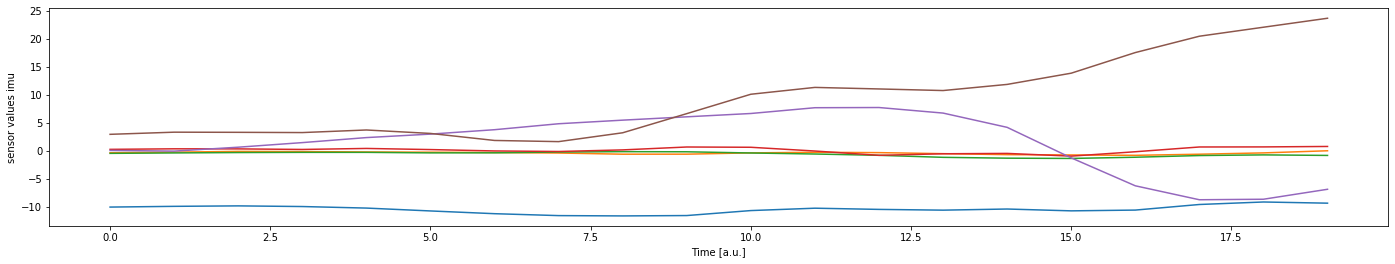

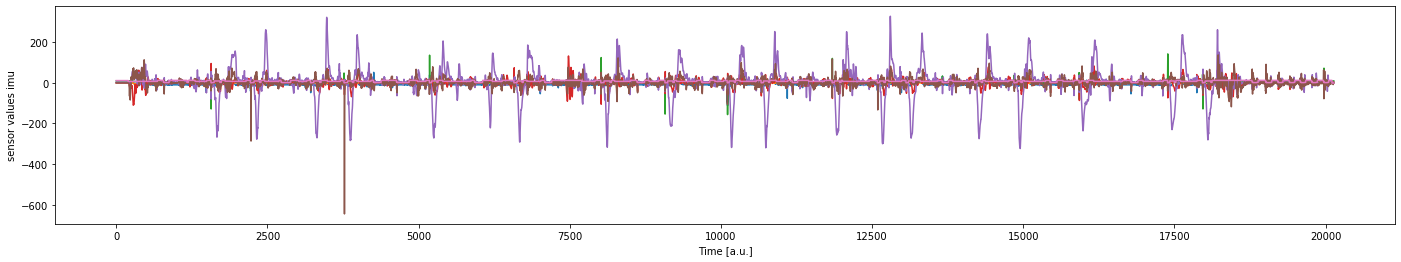

In [6]:
import matplotlib.pyplot as plt
# plot a sample
plt.figure(figsize=(24,4))
plt.plot(Xt_imu[100])
plt.xlabel('Time [a.u.]')
plt.ylabel('sensor values imu')
plt.show()

# plot a dataset
plotme = data[next(iter(data.keys()))].imu
plotme = np.asarray(plotme)
plt.figure(figsize=(24,4))
plt.plot(plotme[:, 1:])
plt.xlabel('Time [a.u.]')
plt.ylabel('sensor values imu')
plt.show()


### preprocess the data
e.g. summarize or filter labels

In [7]:

def filter_labels(labels, X, Xc, y):
    # get labels per window
    y_labels = np.empty([len(y)])
    for i in range(len(y)):
        values, counts = np.unique(y[i], return_counts=True)
        idx = np.argmax(counts)
        if counts[idx] > 0.5 * np.sum(counts):  
            # take label only if it occurs more than 50% of the window
            y_labels[i] = int(values[idx])
        else:
            # else schedule it for removal
            y_labels[i] = -1  
    # get arrays to filter, and make mask
    y_array = np.asarray(y)
    X_array = np.asarray(X)
    Xc_array = np.asarray(Xc)
    mask = np.isin(y_labels, labels, invert=True)  # mask are only the values that we do consider
    y_labels = y_labels[mask]
    # filter
    y_filtered = y_array[mask]
    X_filtered = X_array[mask]
    Xc_filtered = Xc_array[mask]
    print("[INFO] original X:", len(X), X[0].shape)
    print("[INFO] filtered X:", len(X_filtered), X_filtered[0].shape)
    return X_filtered, Xc_filtered, y_filtered

# filter out labels [-1]
# also filter out whole windows, in case there is no majority label 
# e.g. window length of 5, labels could be [1,1,1,1,0] -> okay. but if [1,1,0,0,2] -> discard window.
Xt_imu_f, Xc_imu_f, y_imu_f = filter_labels(labels=[-1], X=Xt_imu, Xc=Xc_imu, y=y_imu)





[INFO] original X: 3901 (20, 6)
[INFO] filtered X: 3817 (20, 6)


In [8]:
def one_label_per_window(y):
    # get labels per window
    y_labels = []
    for i in range(len(y)):
        values, counts = np.unique(y[i], return_counts=True)
        idx = np.argmax(counts)
        # take label only if it occurs more than 50% of the window
        if counts[idx] > 0.5 * np.sum(counts):  
            y_labels.append(int(values[idx]))
    
    print("flattened %i labels: %s" % (len(np.unique(y_labels)),  str(np.unique(y_labels))))
    return y_labels

# flatten labels of windows to the majority label
# [1,1,1,1,2] -> 1. bad if you've got [0,0,0,0,0,1,1,1,1,1,1] -> 1, this creates anomalous samples of class 1
print("pre", y_imu_f[30])
y_imu_f = one_label_per_window(y=y_imu_f)
print("post", y_imu_f[30])



pre [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
flattened 11 labels: [ 0  1  2  3  4  6  7  8  9 11 12]
post 7


In [9]:


def summarize_labels(y, labelsummary=None):
    y_summarized = np.array(y, copy=True)
    y_original = np.array(y, copy=True)
    if labelsummary is not None:
        for key in labelsummary:
            for label in labelsummary[key]:
                mask = np.ma.masked_equal(y_original, label)
                y_summarized[mask.mask] = key
        print("[INFO] Summarized labels from", np.unique(y_original), "to", np.unique(y_summarized))
    print(np.unique(y_summarized, return_counts=True))
    return y_summarized


# some labels are basically very similar, like "pull_trigger, pull_trigger_air" for the Pneumatic Rivet Gun
# Same action, but once holding the tool in the air, once using it on a workpiece.
classes = data[next(iter(data.keys()))].classes
print("all my classes:")
for idx, c in enumerate(classes):
    print(" %i: %s  " %(idx, c))

summarylabels = {0: [0, 3, 4, 5, 6], # pull_trigger {not_removed, air, air_with_rivet, air_with_rivet_not_removed}
                 1: [2],# release_trigger
                 2: [1, 7, 8, 9, 10, 11, 12]} # hold_trigger, positioning, shaking, transport_by_hand, change_nose_piece, idle, undefined
y_imu_f_sum = summarize_labels(y_imu_f, summarylabels)

all my classes:
 0: pull_trigger  
 1: hold_trigger  
 2: release_trigger  
 3: pull_trigger_not_removed  
 4: pull_trigger_air  
 5: pull_trigger_air_with_rivet  
 6: pull_trigger_air_with_rivet_not_removed  
 7: positioning  
 8: shaking  
 9: transport_by_hand  
 10: change_nose_piece  
 11: idle  
 12: undefined  
[INFO] Summarized labels from [ 0  1  2  3  4  6  7  8  9 11 12] to [0 1 2]
(array([0, 1, 2]), array([  87,  146, 3584]))
